<a href="https://colab.research.google.com/github/rlberry-py/tutorials/blob/main/Value%20Iteration%20and%20Q-Learning/Value_Iteration_and_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - Value Iteration and Q-Learning
---------------------------------

In this tutorial, you will:

* Implement the value iteration algorithm to approximate the value function when *a model of the environment is available*.
* Implement the Q-Learning algorithm to approximate the value function when *the model is unknown*, that is, the agent must learn through interactions.

We start with a short review of these algorithms.


## Markov decision processes and value functions

In reinforcement learning, an agent interacts with an enviroment by taking actions and observing rewards. Its goal is to learn a *policy*, that is, a mapping from states to actions, that maximizes the amount of reward it gathers.

The enviroment is modeled as a __Markov decision process (MDP)__, defined by a set of states $\mathcal{S}$, a set of actions $\mathcal{A}$, a reward function $r(s, a)$ and transition probabilities $P(s'|s,a)$. When an agent takes action $a$ in state $s$, it receives a random reward with mean $r(s,a)$ and makes a transion to a state $s'$ distributed according to $P(s'|s,a)$.

A __policy__ $\pi$ is such that $\pi(a|s)$ gives the probability of choosing an action $a$ in state $s$. __If the policy is deterministic__, we denote by $\pi(s)$ the action that it chooses in state $s$. We are interested in finding a policy that maximizes the value function $V^\pi$, defined as 

$$
V^\pi(s) = \sum_{a\in \mathcal{A}} \pi(a|s) Q^\pi(s, a), 
\quad \text{where} \quad 
Q^\pi(s, a) = \mathbf{E}\left[ \sum_{t=0}^\infty \gamma^t r(S_t, A_t)  \Big| S_0 = s, A_0 = a\right].
$$
and represents the mean of the sum of discounted rewards gathered by the policy $\pi$ in the MDP, where $\gamma \in [0, 1[$ is a discount factor ensuring the convergence of the sum. 

The __action-value function__ $Q^\pi$ is the __fixed point of the Bellman operator $T^\pi$__:

$$ 
Q^\pi(s, a) = T^\pi Q^\pi(s, a)
$$
where, for any function $f: \mathcal{S}\times\mathcal{A} \to \mathbb{R}$
$$
T^\pi f(s, a) =  r(s, a) + \gamma \sum_{s'} P(s'|s,a) \left(\sum_{a'}\pi(a'|s')f(s',a')\right) 
$$


The __optimal value function__, defined as $V^*(s) = \max_\pi V^\pi(s)$ can be shown to satisfy $V^*(s) = \max_a Q^*(s, a)$, where $Q^*$ is the __fixed point of the optimal Bellman operator $T^*$__: 

$$ 
Q^*(s, a) = T^* Q^*(s, a)
$$
where, for any function $f: \mathcal{S}\times\mathcal{A} \to \mathbb{R}$
$$
T^* f(s, a) =  r(s, a) + \gamma \sum_{s'} P(s'|s,a) \max_{a'} f(s', a')
$$
and there exists an __optimal policy__ which is deterministic, given by $\pi^*(s) \in \arg\max_a Q^*(s, a)$.


## Value iteration

If both the reward function $r$ and the transition probablities $P$ are known, we can compute $Q^*$ using value iteration, which proceeds as follows:

1. Start with arbitrary $Q_0$, set $t=0$.
2. Compute $Q_{t+1}(s, a) = T^*Q_t(s,a)$ for every $(s, a)$.
3. If $\max_{s,a} | Q_{t+1}(s, a) -  Q_t(s,a)| \leq \varepsilon$, return $Q_{t}$. Otherwise, set $t \gets t+1$ and go back to 2. 

The convergence is guaranteed by the contraction property of the Bellman operator, and $Q_{t+1}$ can be shown to be a good approximation of $Q^*$ for small epsilon. 

__Question__: Can you bound the error $\max_{s,a} | Q^*(s, a) -  Q_t(s,a)|$ as a function of $\gamma$ and $\varepsilon$?

## Q-Learning

In value iteration, we need to know $r$ and $P$ to implement the Bellman operator. When these quantities are not available, we can approximate $Q^*$ using *samples* from the environment with the Q-Learning algorithm.

Q-Learning with __$\varepsilon$-greedy exploration__ proceeds as follows:

1. Start with arbitrary $Q_0$, get starting state $s_0$, set $t=0$.
2. Choosing action $a_t$: 
  * With probability $\varepsilon$ choose $a_t$ randomly (uniform distribution)  
  * With probability $1-\varepsilon$, choose $a_t \in \arg\max_a Q_t(s_t, a)$.
3. Take action $a_t$, observe next state $s_{t+1}$ and reward $r_t$.
4. Compute error $\delta_t = r_t + \gamma \max_a Q_t(s_{t+1}, a) - Q_t(s_t, a_t)$.
5. Update 
  * $Q_{t+1}(s, a) = Q_t(s, a) + \alpha_t(s,a) \delta_t$,  __if $s=s_t$ and $a=a_t$__
  * $Q_{t+1}(s, a) = Q_{t}(s, a)$ otherwise.

Here, $\alpha_t(s,a)$ is a learning rate that can depend, for instance, on the number of times the algorithm has visited the state-action pair $(s, a)$. 


# Colab setup

In [1]:
if 'google.colab' in str(get_ipython()):
  print("Installing packages, please wait a few moments. Restart the runtime after the installation.")

  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@v0.3.0#egg=rlberry[default] > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1


In [2]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# The following code is will be used to visualize the environments.
import base64
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path

def show_video(filename=None, directory='./videos'):
    """
    Either show all videos in a directory (if filename is None) or 
    show video corresponding to filename.
    """
    html = []
    if filename is not None:
        files = Path('./').glob(filename)
    else:
        files = Path(directory).glob("*.mp4")
    for mp4 in files:
        print(mp4)
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
     
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 800))
display.start()

In [1]:
# other required libraries
import numpy as np
import matplotlib.pyplot as plt
import random as rd

In [2]:

#Install required libraries:
!pip install jupyterlab
!pip install git+https://github.com/rlberry-py/rlberry.git@v0.3.0#egg=rlberry[default]

  Cloning https://github.com/rlberry-py/rlberry.git (to revision v0.3.0) to c:\users\utilisateur\appdata\local\temp\pip-install-400lctgn\rlberry_faccdd2af6074e9bb65e486d854411fe
  Resolved https://github.com/rlberry-py/rlberry.git to commit 8ea7532ea27fdc1c5ffb44293f9e350c924f7c65
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/rlberry-py/rlberry.git 'C:\Users\Utilisateur\AppData\Local\Temp\pip-install-400lctgn\rlberry_faccdd2af6074e9bb65e486d854411fe'
  Running command git checkout -q 8ea7532ea27fdc1c5ffb44293f9e350c924f7c65


In [3]:
!pip install ffmpeg-python pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

'apt-get' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


# Warm up: interacting with a reinforcement learning environment

In [4]:
from rlberry.envs import GridWorld

# A GridWorld is an environment where an agent moves in a 2d grid and aims to reach the state which gives a reward.
env = GridWorld(nrows=3, ncols=5, walls=((0,2),(1, 2)), success_probability=0.9)

# Number of states and actions
print("number of states = ", env.observation_space.n)
print("number of actions = ", env.action_space.n)

# Transitions probabilities, env.P[s, a, s'] = P(s'|s, a)
print("transition probabilities from state 0 by taking action 1: ", env.P[0, 1, :])

# Reward function: env.R[s, a] = r(s, a)
print("mean reward in state 0 for action 1 = ", env.R[0, 1])

# Following a random policy 
state = env.reset()     # initial state 
env.enable_rendering()  # save states for visualization
for tt in range(100):   # interact for 100 time steps
  action = env.action_space.sample()  # random action, a good RL agent must have a better strategy!
  next_state, reward, is_terminal, info = env.step(action)
  if is_terminal:
    break
  state = next_state

# save video 
env.save_video('/videos/random_policy.mp4', framerate=10)
# clear rendering data
env.clear_render_buffer()
env.disable_rendering()
# see video
#show_video(filename='./videos/random_policy.mp4')

c:\Users\Utilisateur\anaconda3\envs\rltutorials\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of states =  13
number of actions =  4
transition probabilities from state 0 by taking action 1:  [0.  0.9 0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
mean reward in state 0 for action 1 =  0.0


[WARNING] Not possible to save video, due to exception: [WinError 2] Le fichier spécifié est introuvable 


# Implementing Value Iteration

1. Write a function ``bellman_operator`` that takes as input a function $Q$ and returns $T^* Q$.
2. Write a function  ``value_iteration`` that returns a function $Q$ such that $||Q-T^* Q||_\infty \leq \varepsilon$
3. Evaluate the performance of the policy $\pi(s) = \arg\max_a Q(s, a)$, where Q is returned by ``value_iteration``.

In [22]:
def bellman_operator(Q, env, gamma=0.99):
  S = env.observation_space.n
  A = env.action_space.n 
  TQ = np.zeros((S, A))

  for state in range(S):
    for action in range(A):
      sum=0
      for s in range(S):
        q=np.max(Q[s,:])
        sum+=q*env.P[state,action,s]
      TQ[state,action]=env.R[state,action]+gamma*sum
  return TQ

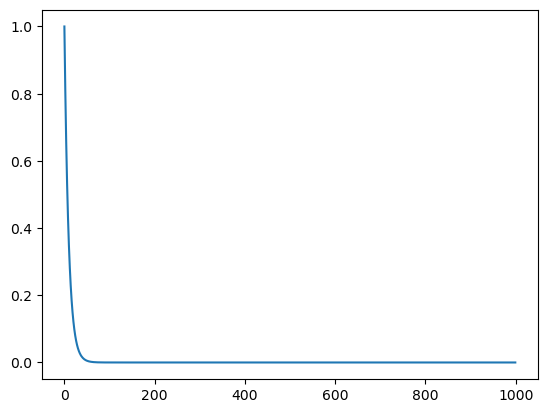

[[ 4.32422223  4.76466083  4.80469137  4.32422223]
 [ 4.43136507  4.75965702  5.2885078   4.75965702]
 [ 6.34669824  6.99520462  7.05188693  6.34669824]
 [ 6.50424032  6.98811933  7.76457703  6.98811933]
 [ 4.80969519  5.3421918   5.34410576  4.43147766]
 [ 4.87319184  5.39565064  5.99516738  4.8306594 ]
 [ 7.05897222  7.84330246  7.84252707  6.50419471]
 [ 7.15248096  7.92211912  8.80235458  7.09225601]
 [ 5.39790236  5.99766928  5.39790236  4.94169231]
 [ 5.47628703  6.81074045  6.12966641  5.47437307]
 [ 6.30882045  7.74205284  6.96784756  6.96784756]
 [ 7.07401141  8.80134099  7.92120689  7.15146737]
 [ 8.92129811 10.         10.          8.9220279 ]]


In [26]:
S = env.observation_space.n
A = env.action_space.n 
Q = np.zeros((S, A))
tabError=[]
for i in range(1000):
  TQ=bellman_operator(Q,env=env,gamma=0.9)
  tabError.append(np.max(np.abs(TQ-Q)))
  Q=TQ
plt.figure()
plt.plot(tabError)
plt.show()
print(Q)

In [31]:
def value_iteration(env, gamma=0.99, epsilon=1e-6,Niter=10000):
  S = env.observation_space.n
  A = env.action_space.n 
  Q = np.zeros((S, A))
  Q_prev = np.zeros((S, A))
  TabError=[]
  t=0
  while t<Niter:
    Q_prev=Q
    Q=bellman_operator(Q,env,gamma)
    error=np.max(np.abs(Q-Q_prev))
    TabError.append(error)
    if error<epsilon:
      break
  return Q,TabError

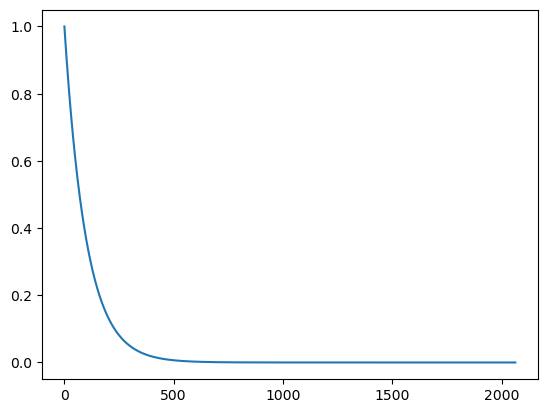

[[92.20279646 93.05224864 93.13413783 92.20279646]
 [92.40046694 93.04201249 93.9818308  93.04201249]
 [95.72028829 96.60578778 96.68715989 95.72028829]
 [95.92595954 96.59561627 97.57132957 96.59561627]
 [93.14437398 94.08091939 94.08522625 92.40072028]
 [93.24989777 94.17950128 95.13080938 93.1628905 ]
 [96.6973314  97.67407213 97.67248998 95.92586648]
 [96.80737907 97.77700082 98.76464729 96.72092121]
 [94.18456818 95.13592745 94.18456818 93.3656577 ]
 [94.30298708 96.32041533 95.35721117 94.29868022]
 [95.599004   97.53334664 96.55801317 96.55801317]
 [96.68707842 98.76276714 97.77513947 96.80549892]
 [98.7753256  99.9999999  99.9999999  98.77681469]]


In [34]:
itermax=10000

Q,tabError=value_iteration(env=env,gamma=0.99,epsilon=0.000000001,Niter=itermax)
plt.figure()
plt.plot(tabError)
plt.show()
print(Q)

In [17]:
Q_vi = value_iteration(env)
print(Q_vi)

(array([[92.20269792, 93.05215011, 93.1340393 , 92.20269792],
       [92.4003684 , 93.04191396, 93.98173227, 93.04191396],
       [95.72018976, 96.60568925, 96.68706136, 95.72018976],
       [95.92586101, 96.59551774, 97.57123103, 96.59551774],
       [93.14427545, 94.08082085, 94.08512771, 92.40062175],
       [93.24979923, 94.17940275, 95.13071084, 93.16279197],
       [96.69723287, 97.67397359, 97.67239144, 95.92576794],
       [96.80728054, 97.77690229, 98.76454876, 96.72082267],
       [94.18446964, 95.13582892, 94.18446964, 93.36555917],
       [94.30288855, 96.32031679, 95.35711264, 94.29858169],
       [95.59890547, 97.5332481 , 96.55791464, 96.55791464],
       [96.68697988, 98.7626686 , 97.77504093, 96.80540038],
       [98.77522707, 99.99990137, 99.99990137, 98.77671615]]), [1.0, 0.99, 0.9801, 0.9702989999999998, 0.9605960100000002, 0.9509900498999997, 0.9414801494010003, 0.93206534790699, 0.9227446944279203, 0.9135172474836413, 0.9043820750088045, 0.895338254258716, 0.88638

In [16]:

# Following value iteration policy 
state = env.reset()     
env.enable_rendering()  
for tt in range(100):   
  action = Q_vi[state, :].argmax()
  next_state, reward, is_terminal, info = env.step(action)
  if is_terminal:
    break
  state = next_state

# save video (run last cell to visualize it!)
env.save_video('./videos/value_iteration_policy.mp4', framerate=10)
# clear rendering data
env.clear_render_buffer()
env.disable_rendering()
# see video
show_video(filename='./videos/value_iteration_policy.mp4')

KeyboardInterrupt: 

# Implementing Q-Learning

Implement a function ``q_learning`` that takes as input an environment, runs Q learning for $T$ time steps and returns $Q_T$. 

Test different learning rates:
  * $\alpha_t(s, a) = \frac{1}{\text{number of visits to} (s, a)}$
  * $\alpha_t(s, a) =$ constant in $]0, 1[$
  * others?

Test different initializations of the Q function and try different values of $\varepsilon$ in the $\varepsilon$-greedy exploration!

It might be very useful to plot the difference between the Q-learning approximation and the output of value iteration above, as a function of time.


In [42]:
def q_learning(env, gamma=0.99, T=5000, Q_vi=None):
  """
  Q_vi is the output of value iteration.
  """
  epsilon=0.5
  S = env.observation_space.n
  A = env.action_space.n 
  error = np.zeros(T)
  Q = np.zeros((S, A))  # can we improve this initialization? 
  #Choix du alpha : 
  alpha=0.5

  state = env.reset()
    # to complete...
  for tt in range(T):
    # choose action a_t
    rand=rd.uniform(0,1)
    if rand<epsilon:
      action = rd.randint(0,A-1)
    else:
      action = np.max(Q[state,:])
    # take action, observe next state and reward 
    nex_state,reward,isTerminal,info = env.step(action)
    # compute delta_t
    delta_t=reward+gamma*(np.max(Q[next_state,:]))-Q[state,action]
    # update Q
    Q[state,action]=Q[state,action]+alpha*delta_t
    Q_vi=value_iteration(env=env,gamma=0.99,epsilon=0.0000001)
    
    error[tt] = np.abs(Q-Q_vi).max()
  
  plt.plot(error)
  plt.xlabel('iteration')
  plt.title('Q-Learning error')
  plt.show()
  
  return Q 

In [43]:
Q_ql = q_learning(env, Q_vi=Q_vi)

# Following Q-Learning policy 
state = env.reset()     
env.enable_rendering()  
for tt in range(100):   
  action = Q_ql[state, :].argmax()
  next_state, reward, is_terminal, info = env.step(action)
  if is_terminal:
    break
  state = next_state

# save video (run last cell to visualize it!)
env.save_video('./videos/q_learning_policy.mp4', framerate=10)
# clear rendering data
env.clear_render_buffer()
env.disable_rendering()
# see video
show_video(filename='./videos/q_learning_policy.mp4')

AssertionError: Invalid action!